# BLE Proximity Experiment - SVR
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Initialize Dataset
Initialization of the data from the file

In [3]:
dataset = load_file('../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
#distance_proximity_experiments were made with purple beacon
display(dataset)
display(dataset.shape)

coordinate_X  coordinate_Y  rssi_Value  rolling_mean_rssi  distance
0             0.0           0.5         -75         -75.000000       0.5
1             0.0           0.5         -76         -75.500000       0.5
2             0.0           0.5         -75         -75.333333       0.5
3             0.0           0.5         -74         -75.000000       0.5
4             0.0           0.5         -76         -75.200000       0.5
..            ...           ...         ...                ...       ...
360           0.0           4.0         -83         -84.500000       4.0
361           0.0           4.0         -91         -86.666667       4.0
362           0.0           4.0         -87         -87.000000       4.0
363           0.0           4.0         -86         -86.500000       4.0
364           0.0           4.0         -90         -90.000000       4.0

[365 rows x 5 columns]

(365, 5)

### File Overall Description
Usage of describe pandas function on the dataset

In [4]:
display(dataset.describe().transpose())

count       mean       std   min   25%   50%   75%    max
coordinate_X       365.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.00
coordinate_Y       365.0   2.115068  1.094024   0.5   1.0   2.0   3.0   4.00
rssi_Value         365.0 -81.435616  3.875018 -92.0 -84.0 -82.0 -79.0 -73.00
rolling_mean_rssi  365.0 -81.470254  3.465669 -92.0 -84.0 -82.0 -79.0 -74.75
distance           365.0   2.115068  1.094024   0.5   1.0   2.0   3.0   4.00

### Scanned Distances
Graphical display of the distances beacon/smartphone scanned in the experiment

In [5]:
distances = dataset['distance']
reference_points = dataset.groupby(['distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

In [6]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

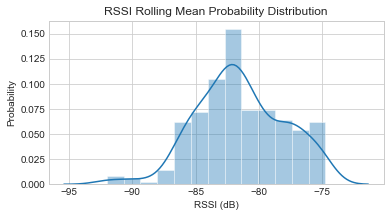

In [7]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

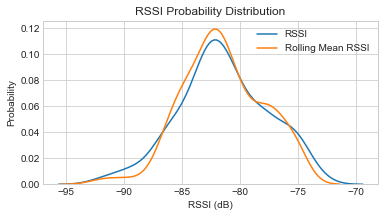

In [8]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [9]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
train_Y = pd.DataFrame(dataset['distance']).values.reshape(-1,1)
default_groups = dataset['distance'].map(str)
data_plot_means = dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

# FREE PARAMETERS
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
C_parameter_list = [0.25,0.5,1.0,10.0,100.0,1000.0] 
kernel_list = ("linear","poly","rbf","sigmoid")
gamma_list = [10,100,"scale","auto"]
epsilon_list = [0.1,0.2,0.3]

rssi_Value  rolling_mean_rssi
distance                               
0.5       -76.111111         -76.341498
1.0       -82.454545         -82.086742
1.5       -80.489796         -80.442177
2.0       -82.937500         -82.730398
2.5       -82.692308         -82.727106
3.0       -82.734694         -83.166667
3.5       -81.139535         -81.082171
4.0       -85.307692         -85.621154

### Plot Training Data
Graphical Display of the observations in the dataset

In [10]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Distance (m)')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [11]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

### SVR Experiments
Experiments with SVR algorithm

In [12]:
def compute_SVR(flag=0,colors=None,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                            cross_validation = None,C_parameter = 1.0, kernel_parameter='rbf', gamma_parameter="scale",
                epsilon_value =0.1):
    # Init the Linear Regressor Estimator
    svr_estimator = SVR(C=C_parameter,kernel=kernel_parameter,gamma=gamma_parameter,epsilon=epsilon_value)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,svr_estimator)
    else:
        main_estimator = svr_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        main_estimator.fit(testX_data,testY_data)
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    statistical_array = list()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        display(error_dataframe)
        df1 = error_dataframe.head(25)
        df1.plot(kind='bar',figsize=(12,6))
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()
        X_grid = np.arange(min(testX_data), max(testX_data), 0.01) #this step required because data is feature scaled.
        X_grid = X_grid.reshape((len(X_grid), 1))
        plt.scatter(testX_data, testY_data, color = 'red')
        plt.plot(X_grid, main_estimator.predict(X_grid), color = 'blue')
        plt.title('Truth or Bluff (SVR)')
        plt.xlabel('RSSI')
        plt.ylabel('Distance')
        plt.show()
        plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
        plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
        plt.xlim(testY_data.min()-1, testY_data.max()+1)
        plt.ylim(testX_data.min()-1, testX_data.max()+1)
        plt.xticks(np.arange(testY_data.min(), testY_data.max()+1, 1.0))
        plt.yticks(np.arange(testX_data.min(), testX_data.max()+1, 2.0))
        if colors is not None:
            plt.plot(predict_test, testX_data, color=colors,label='SVR')
        else:
            plt.plot(predict_test, testX_data, color='red', label='SVR')
        # Show and place the legent
        plt.legend(loc='upper right')
        plt.show()
    observed_errors = error_dataframe['Predicted'] - error_dataframe['Actual']
    error = pd.DataFrame(observed_errors, columns=["error"])
    result = pd.DataFrame(train_Y,columns=["distance"]).join(error)
    return structure_data(result,coefficient_determination)


#### 1st Experiment - Check Overfitting scenario (Without Testing Data) Using RSSI
Use SVR to check the results on the training data alone

Actual  Predicted
0       0.5   0.523905
1       0.5   0.718245
2       0.5   0.523905
3       0.5   0.501311
4       0.5   0.718245
..      ...        ...
360     4.0   2.600254
361     4.0   2.106190
362     4.0   2.221737
363     4.0   2.399630
364     4.0   2.099492

[365 rows x 2 columns]

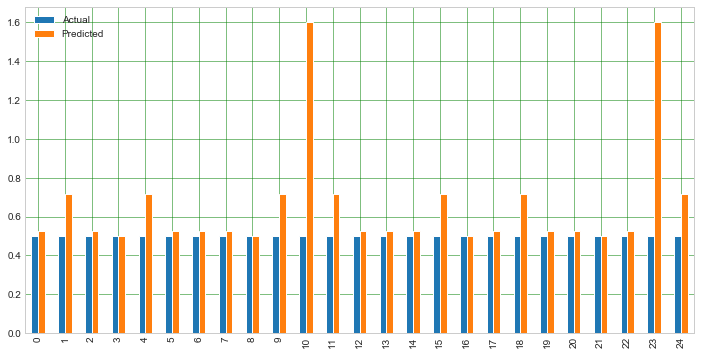

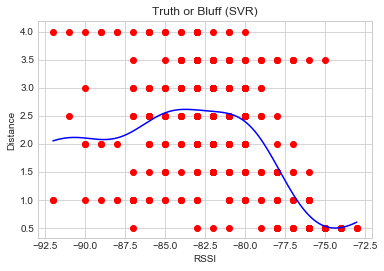

mae       mse      rmse       std       .25       0.5      0.75  \
0  0.696216  0.828225  0.910068  0.911157 -0.466437  0.033563  0.533563   

      0.95       min       max  r-squared  
0  1.39963 -2.976095  2.100254   0.306117

In [13]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_SVR(flag=1,trainX_data=train_X_rssi,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rssi,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 2nd Experiment - Check Overfitting scenario (Without Testing Data) Using Rolling Mean
Use SVR to check the results on the training data alone

Actual  Predicted
0       0.5   0.571408
1       0.5   0.554804
2       0.5   0.553993
3       0.5   0.571408
4       0.5   0.557952
..      ...        ...
360     4.0   2.605504
361     4.0   3.072724
362     4.0   3.131531
363     4.0   3.034373
364     4.0   2.041543

[365 rows x 2 columns]

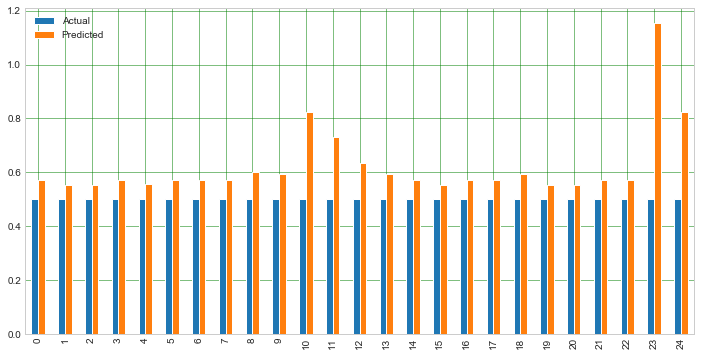

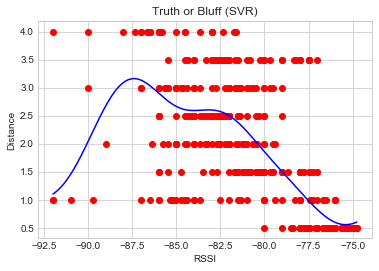

mae       mse      rmse       std       .25       0.5      0.75  \
0  0.66028  0.780409  0.883408  0.881759 -0.595813  0.071408  0.354893   

       0.95       min       max  r-squared  
0  1.400166 -2.900156  2.131531   0.346176

In [14]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_SVR(flag=1,trainX_data=train_X_rolling_mean,trainY_data=train_Y.ravel(),
                                   testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

#### 3rd Experiment - SVR with StratifiedKFold (RSSI pure)
Experiment using cross validation approach of StratifiedKFold

Actual  Predicted
0       0.5   0.599643
1       0.5   0.811959
2       0.5   0.599643
3       0.5   0.539852
4       0.5   0.811959
..      ...        ...
360     4.0   2.660174
361     4.0   2.077059
362     4.0   2.539034
363     4.0   2.600086
364     4.0   2.100258

[365 rows x 2 columns]

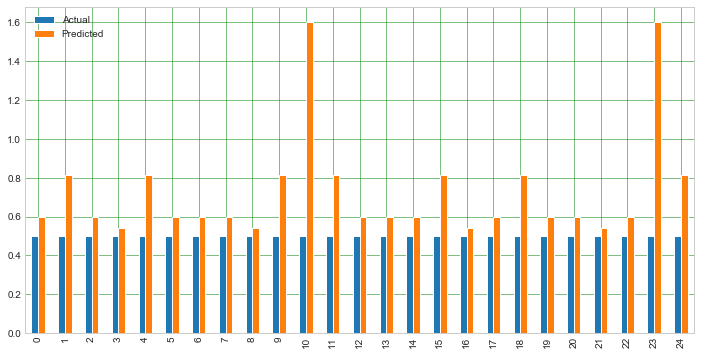

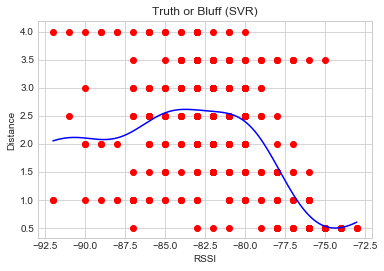

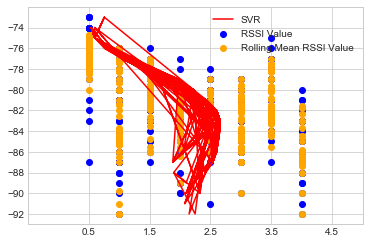

Actual  Predicted
0       0.5   0.442470
1       0.5   0.600028
2       0.5   0.442470
3       0.5   0.461741
4       0.5   0.600028
..      ...        ...
360     4.0   2.625700
361     4.0   1.364612
362     4.0   2.546053
363     4.0   2.599629
364     4.0   1.730178

[365 rows x 2 columns]

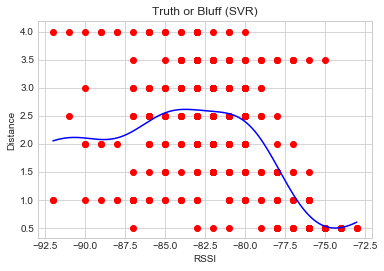

Actual  Predicted
0       0.5   0.513266
1       0.5   0.708581
2       0.5   0.513266
3       0.5   0.496222
4       0.5   0.708581
..      ...        ...
360     4.0   2.599920
361     4.0   1.612516
362     4.0   2.491794
363     4.0   2.567647
364     4.0   1.899852

[365 rows x 2 columns]

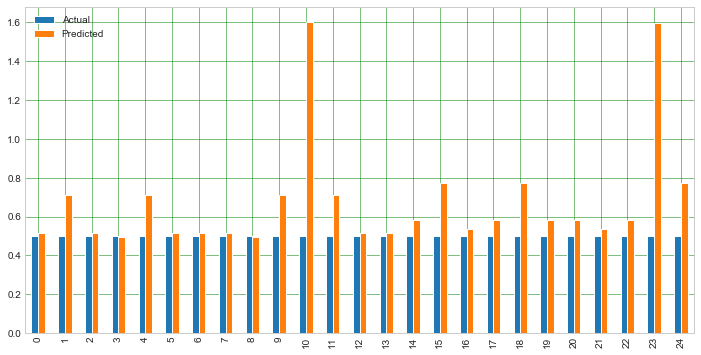

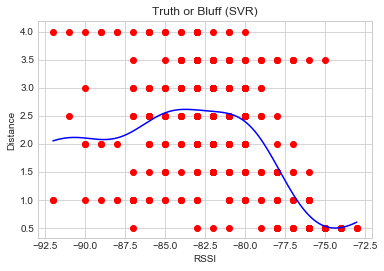

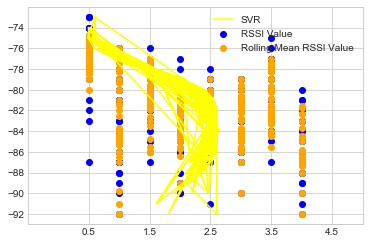

mae       mse      rmse       std       .25       0.5      0.75  \
2  0.722718  0.883756  0.940083  0.940850 -0.600472  0.060960  0.528226   
1  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
0  0.732008  0.884183  0.940310  0.939365 -0.600244  0.099643  0.399756   

       0.95       min       max  r-squared  folds  
2  1.492282 -3.015248  2.099920   0.259593      4  
1  1.513532 -3.026756  2.153066   0.238449      3  
0  1.431722 -2.899870  2.160174   0.259236      2

Number of Folds:  4


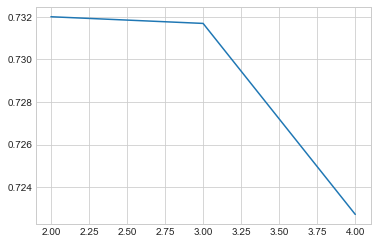

In [15]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,5)
colors = ['red','blue','yellow']
counter = 0
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rssi,default_groups,default_groups)
    result = compute_SVR(flag = 1,colors=colors[counter],testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 4th Experiment - SVR with StratifiedKFold (Rolling Mean)
Experiment using cross validation approach of StratifiedKFold

Actual  Predicted
0       0.5   0.541004
1       0.5   0.454133
2       0.5   0.477485
3       0.5   0.541004
4       0.5   0.500391
..      ...        ...
360     4.0   2.631773
361     4.0   3.434553
362     4.0   3.582063
363     4.0   3.356398
364     4.0   3.960557

[365 rows x 2 columns]

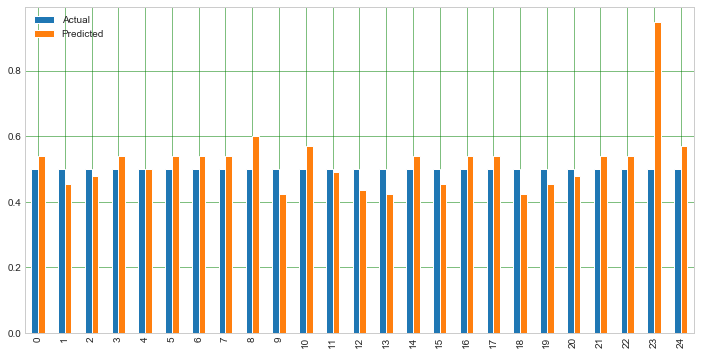

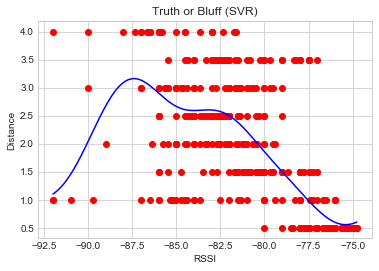

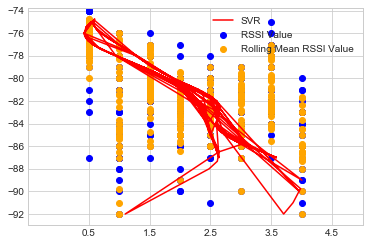

Actual  Predicted
0       0.5   0.554337
1       0.5   0.499528
2       0.5   0.511838
3       0.5   0.554337
4       0.5   0.526098
..      ...        ...
360     4.0   2.544604
361     4.0   2.995262
362     4.0   3.033045
363     4.0   2.964472
364     4.0   1.745472

[365 rows x 2 columns]

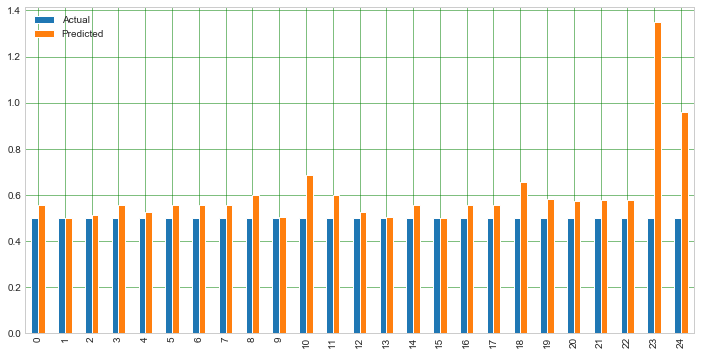

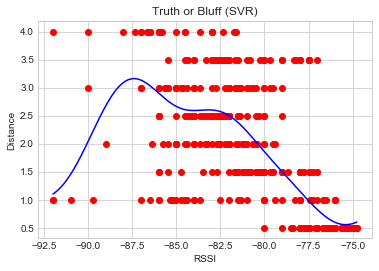

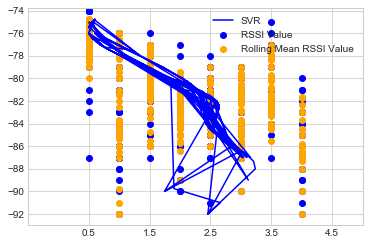

Actual  Predicted
0       0.5   0.560334
1       0.5   0.524963
2       0.5   0.529703
3       0.5   0.560334
4       0.5   0.538685
..      ...        ...
360     4.0   2.480922
361     4.0   2.869182
362     4.0   2.907611
363     4.0   2.839166
364     4.0   1.698870

[365 rows x 2 columns]

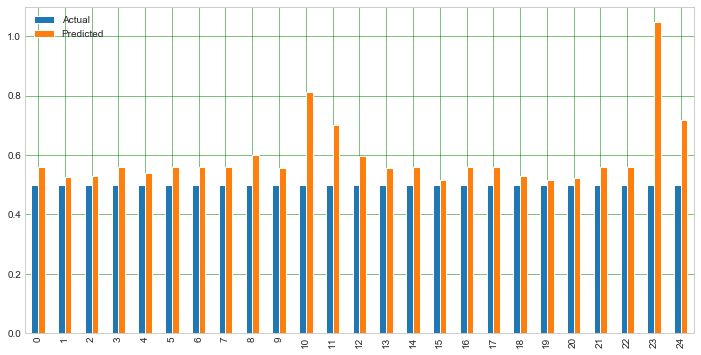

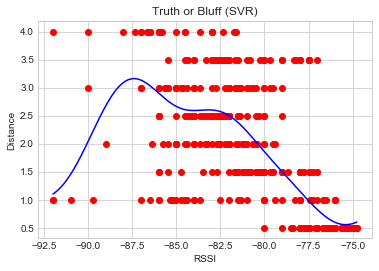

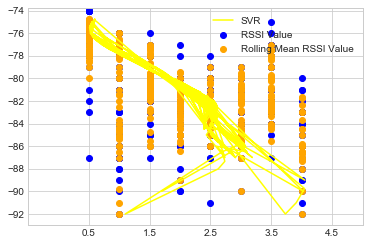

mae       mse      rmse       std       .25       0.5      0.75  \
1  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
0  0.719597  0.929772  0.964247  0.963240 -0.643602 -0.022515  0.372632   
2  0.719745  0.909518  0.953686  0.951436 -0.641316  0.046842  0.399242   

       0.95       min       max  r-squared  folds  
1  1.426808 -2.671598  2.033045   0.302213      3  
0  1.619910 -2.900266  2.978825   0.221041      2  
2  1.480922 -2.899902  3.045838   0.238010      4

Number of Folds:  3


In [16]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(2,5)
results = list()
colors = ['red','blue','yellow']
counter = 0
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(train_X_rolling_mean,default_groups)
    result = compute_SVR(flag = 1,colors=colors[counter],testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
    counter = counter + 1
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### 5th Experiment - SVR with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

mae       mse      rmse       std       .25       0.5      0.75  \
5  0.702665  0.803747  0.896519  0.898331 -0.600338  0.099919  0.416686   
3  0.698197  0.806461  0.898032  0.900301 -0.579229  0.099652  0.399592   
6  0.698523  0.806896  0.898274  0.899277 -0.599642  0.099775  0.469355   
4  0.708762  0.820268  0.905686  0.908022 -0.533284  0.099794  0.471754   
8  0.712105  0.832355  0.912335  0.912592 -0.474433  0.099677  0.548079   
2  0.734268  0.861688  0.928271  0.929512 -0.675449  0.052492  0.485439   
7  0.723576  0.885759  0.941148  0.942172 -0.575643  0.099751  0.401739   
1  0.746428  0.884054  0.940241  0.946372 -0.599878  0.100137  0.524273   
0  0.790789  0.999992  0.999996  1.002630 -0.772557 -0.059357  0.415311   

       0.95       min       max  r-squared  test_size  
5  1.240350 -2.648232  2.239982   0.326993        0.6  
3  1.400229 -2.486904  2.123359   0.321980        0.4  
6  1.367295 -2.900225  2.021766   0.321796        0.7  
4  1.361602 -2.653389  2.099701   0.309696        0.5  
8  1.548079 -2.900323  2.106483   0.302663        0.9  
2  1.363038 -2.484908  1.995801   0.277648        0.3  
7  1.424357 -2.900249  2.374995   0.255795        0.8  
1  1.447802 -2.482232  2.019321   0.251073        0.2  
0  1.194907 -2.524428  2.060146   0.188026        0.1

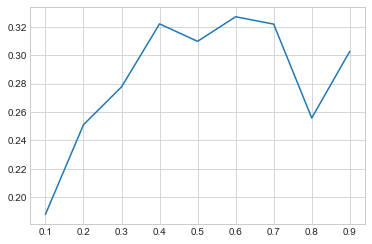

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rssi,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 6th Experiment - SVR with HoldOut (Rolling Mean)
Experiment using cross validation approach of HoldOut (Train test split)

mae       mse      rmse       std       .25       0.5      0.75  \
3  0.641071  0.728262  0.853383  0.854958 -0.501058  0.070484  0.363493   
0  0.669428  0.788109  0.887755  0.879623 -0.494085 -0.104642  0.198936   
5  0.662734  0.793091  0.890556  0.887421 -0.618627  0.063610  0.375382   
4  0.662373  0.810201  0.900112  0.894417 -0.599743  0.057064  0.282843   
6  0.671114  0.818330  0.904616  0.903717 -0.659668  0.052293  0.371344   
8  0.690977  0.851464  0.922748  0.922666 -0.675186  0.100244  0.324814   
2  0.701427  0.864646  0.929863  0.929920 -0.700294  0.077391  0.303207   
7  0.700374  0.865980  0.930581  0.930970 -0.616262  0.099965  0.385709   
1  0.713798  0.922627  0.960535  0.963895 -0.433538  0.074922  0.396686   

       0.95       min       max  r-squared  test_size  
3  1.465972 -2.487977  1.742403   0.387724        0.4  
0  0.992239 -2.291568  1.583312   0.360070        0.1  
5  1.378926 -2.899985  2.044848   0.335916        0.6  
4  1.400222 -2.899667  2.056708   0.318168        0.5  
6  1.456613 -2.811403  2.289498   0.312185        0.7  
8  1.649483 -2.679632  2.033903   0.286653        0.9  
2  1.582301 -2.573723  2.100306   0.275169        0.3  
7  1.431872 -2.708415  1.901608   0.272414        0.8  
1  1.546957 -2.558091  1.899963   0.218396        0.2

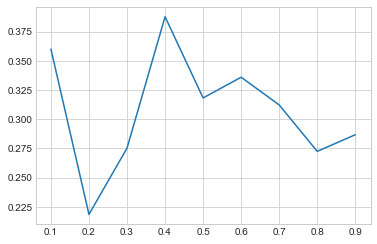

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(train_X_rolling_mean,train_Y.ravel(), test_size = size, random_state = 6,stratify=default_groups)
    result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['r-squared'],ascending=False))
plt.plot(statistics['test_size'],statistics['r-squared'])

#### 7th Experiment - SVR with LOGO (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rssi,train_Y,groups=default_groups)
loo = compute_SVR(testX_data=train_X_rssi,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae       mse      rmse       std       .25       0.5      0.75  \
0  0.959009  1.231886  1.109904  1.110428 -0.820506  0.155847  0.837876   

       0.95       min       max  r-squared  
0  1.608133 -3.076505  2.100423  -0.032069

#### 8th Experiment - SVR with LOGO (Rolling Mean)
Experiment using cross validation approach of Leave One Group Out

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(train_X_rolling_mean,train_Y,groups=default_groups)
loo = compute_SVR(testX_data=train_X_rolling_mean,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae       mse      rmse       std       .25       0.5      0.75  \
0  0.923196  1.243303  1.115035  1.116377 -0.786655  0.217583  0.613265   

       0.95       min       max  r-squared  
0  1.608343 -2.900171  2.692092  -0.041634

#### 9th Experiment - Best cross-validation technique
Best parameters found using SVR

mae       mse      rmse       std       .25       0.5      0.75  \
5  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
4  0.701427  0.864646  0.929863  0.929920 -0.700294  0.077391  0.303207   
2  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
1  0.734268  0.861688  0.928271  0.929512 -0.675449  0.052492  0.485439   
3  0.923196  1.243303  1.115035  1.116377 -0.786655  0.217583  0.613265   
0  0.959009  1.231886  1.109904  1.110428 -0.820506  0.155847  0.837876   

       0.95       min       max  r-squared             method  \
5  1.426808 -2.671598  2.033045   0.302213  Stratified K-Fold   
4  1.582301 -2.573723  2.100306   0.275169            HoldOut   
2  1.513532 -3.026756  2.153066   0.238449  Stratified K-Fold   
1  1.363038 -2.484908  1.995801   0.277648            HoldOut   
3  1.608343 -2.900171  2.692092  -0.041634                LOO   
0  1.608133 -3.076505  2.100423  -0.032069                LOO   

                type  
5  Rolling Mean RSSI  
4  Rolling Mean RSSI  
2          RSSI Only  
1          RSSI Only  
3  Rolling Mean RSSI  
0          RSSI Only

Selected cross validation method:  Stratified K-Fold


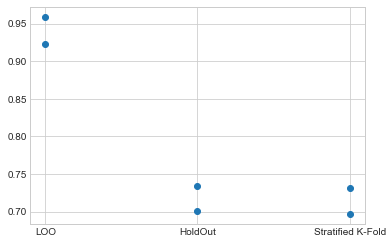

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
    holdout = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
    loo = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(scannedType)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(scannedType)
    results.append(holdout)
    skf = StratifiedKFold(n_splits=selected_fold)
    splited = skf.split(trainX_data,default_groups,groups=default_groups)
    skfold = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)
    skfold.append('Stratified K-Fold')
    skfold.append(scannedType)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'],'o')
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### 10th Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

mae       mse      rmse       std       .25       0.5      0.75  \
7  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
4  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
5  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
6  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
2  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
3  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
0  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
1  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   

       0.95       min       max  r-squared   preprocessing  \
7  1.426808 -2.671598  2.033045   0.302213            None   
4  1.426808 -2.671598  2.033045   0.302213  StandardScaler   
5  1.426808 -2.671598  2.033045   0.302213    MinMaxScaler   
6  1.426808 -2.671598  2.033045   0.302213    MaxAbsScaler   
2  1.513532 -3.026756  2.153066   0.238449    MaxAbsScaler   
3  1.513532 -3.026756  2.153066   0.238449            None   
0  1.513532 -3.026756  2.153066   0.238449  StandardScaler   
1  1.513532 -3.026756  2.153066   0.238449    MinMaxScaler   

                                   preprocessingFunc               type  
7                                               None  Rolling Mean RSSI  
4  StandardScaler(copy=True, with_mean=True, with...  Rolling Mean RSSI  
5      MinMaxScaler(copy=True, feature_range=(0, 1))  Rolling Mean RSSI  
6                            MaxAbsScaler(copy=True)  Rolling Mean RSSI  
2                            MaxAbsScaler(copy=True)          RSSI Only  
3                                               None          RSSI Only  
0  StandardScaler(copy=True, with_mean=True, with...          RSSI Only  
1      MinMaxScaler(copy=True, feature_range=(0, 1))          RSSI Only

Selected Preprocessing:  None


#### 11th Experiment - Running the SVR function with the different kernels

mae         mse       rmse        std       .25           0.5  \
6   0.696325    0.832885   0.912625   0.908564 -0.677435  2.966599e-02   
4   0.711122    0.958237   0.978896   0.978033 -0.633333  3.571563e-03   
2   0.731694    0.908993   0.953411   0.953221 -0.600249 -2.675570e-02   
0   0.784280    1.040383   1.019992   1.019261 -0.800000  6.335258e-07   
5   0.855310    1.710024   1.307679   1.309160 -0.805470  8.711796e-02   
1   0.882192    1.239359   1.113265   1.114782 -0.900000  4.928050e-02   
7   8.884392  129.284861  11.370350  11.134895 -5.120250  3.697567e+00   
3  10.452777  168.863509  12.994749  12.717265 -5.348559  4.674423e+00   

        0.75       0.95        min        max   r-squared   kernel  \
6   0.359841   1.426808  -2.671598   2.033045    0.302213      rbf   
4   0.300000   1.725857  -2.489286   3.425001    0.197193   linear   
2   0.400202   1.513532  -3.026756   2.153066    0.238449      rbf   
0   0.344445   1.700001  -2.700001   3.044447    0.128372   linear   
5   0.532357   1.436626  -1.900178   9.546465   -0.432651     poly   
1   0.571681   1.575061  -2.354953   5.512677   -0.038330     poly   
7   8.157861  19.795605 -43.266257  39.239957 -107.314288  sigmoid   
3  10.293955  22.818283 -39.271751  47.078843 -140.473105  sigmoid   

                type  
6  Rolling Mean RSSI  
4  Rolling Mean RSSI  
2          RSSI Only  
0          RSSI Only  
5  Rolling Mean RSSI  
1          RSSI Only  
7  Rolling Mean RSSI  
3          RSSI Only

Selected Kernel:  rbf


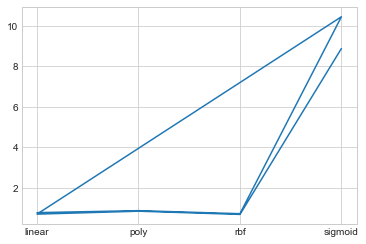

In [23]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','kernel','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for kernel in kernel_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                kernel_parameter=kernel)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),kernel_parameter=kernel)
        result.append(kernel)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['kernel'],statistics['mae'])
selected_kernel = statistics.sort_values(by=['mae'])['kernel'].head(1).values[0]
print("Selected Kernel: ",selected_kernel)

#### 12th Experiment - Running the SVR function with the different C parameters

mae       mse      rmse       std       .25       0.5      0.75  \
8   0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
6   0.696668  0.827307  0.909564  0.903639 -0.714507  0.043229  0.342906   
7   0.698136  0.832841  0.912601  0.909021 -0.680872  0.041754  0.364398   
9   0.704704  0.853480  0.923840  0.923109 -0.600371  0.029040  0.400270   
10  0.713472  0.898995  0.948153  0.947905 -0.600152  0.023295  0.368765   
0   0.725087  0.880551  0.938377  0.938752 -0.599812  0.076414  0.449039   
1   0.729057  0.897839  0.947544  0.947144 -0.600541 -0.043975  0.399544   
2   0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
3   0.753967  0.964691  0.982187  0.982201 -0.600234  0.059857  0.400081   
4   0.765986  1.006612  1.003301  1.004098 -0.599671 -0.026645  0.439494   
5   0.774824  1.040430  1.020015  1.021369 -0.599952 -0.009012  0.400406   
11  0.876992  3.816363  1.953551  1.955031 -0.647035 -0.045953  0.376999   

        0.95       min        max  r-squared  C_parameter               type  
8   1.426808 -2.671598   2.033045   0.302213         1.00  Rolling Mean RSSI  
6   1.392809 -2.682246   1.693524   0.306886         0.25  Rolling Mean RSSI  
7   1.481526 -2.669693   1.899790   0.302249         0.50  Rolling Mean RSSI  
9   1.414470 -2.674848   2.843208   0.284959        10.00  Rolling Mean RSSI  
10  1.419049 -2.927401   2.931305   0.246826       100.00  Rolling Mean RSSI  
0   1.399743 -2.917580   2.230333   0.262278         0.25          RSSI Only  
1   1.469960 -3.043975   2.187778   0.247794         0.50          RSSI Only  
2   1.513532 -3.026756   2.153066   0.238449         1.00          RSSI Only  
3   1.585337 -3.011742   2.147145   0.191786        10.00          RSSI Only  
4   1.556177 -3.071954   2.400395   0.156665       100.00          RSSI Only  
5   1.688531 -3.100083   2.900220   0.128332      1000.00          RSSI Only  
11  1.403894 -3.173115  19.047464  -2.197332      1000.00  Rolling Mean RSSI

Selected C Parameter:  1.0


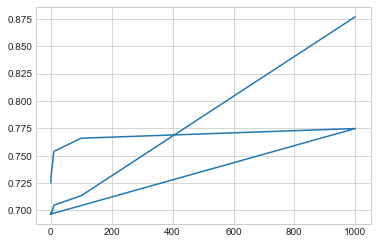

In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','C_parameter','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for C_param in C_parameter_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                C_parameter=C_param)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                C_parameter=C_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),C_parameter=C_param)
        result.append(C_param)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['C_parameter'],statistics['mae'])
selected_c_parameter = statistics.sort_values(by=['mae'])['C_parameter'].head(1).values[0]
print("Selected C Parameter: ",selected_c_parameter)

#### 13th Experiment - Running the SVR function with the different gamma parameters

mae       mse      rmse       std       .25       0.5      0.75  \
6  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
7  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
3  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
2  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
4  0.733290  0.883963  0.940193  0.931774 -0.859529  0.054849  0.400300   
5  0.763347  0.962933  0.981291  0.972972 -0.898660  0.099690  0.399748   
0  0.778439  1.015078  1.007511  1.007698 -0.600392  0.099744  0.400164   
1  0.782060  1.022010  1.010945  1.010598 -0.600107  0.099842  0.400121   

       0.95       min       max  r-squared  gamma gammaStr               type  
6  1.426808 -2.671598  2.033045   0.302213  scale    scale  Rolling Mean RSSI  
7  1.426808 -2.671598  2.033045   0.302213   auto     auto  Rolling Mean RSSI  
3  1.513532 -3.026756  2.153066   0.238449   auto     auto          RSSI Only  
2  1.513532 -3.026756  2.153066   0.238449  scale    scale          RSSI Only  
4  1.298535 -2.895729  2.237245   0.259420     10       10  Rolling Mean RSSI  
5  1.399798 -2.900239  2.899854   0.193259    100      100  Rolling Mean RSSI  
0  1.593099 -2.900139  2.510456   0.149572     10       10          RSSI Only  
1  1.599985 -2.900158  2.399987   0.143765    100      100          RSSI Only

Selected Gamma Parameter:  scale


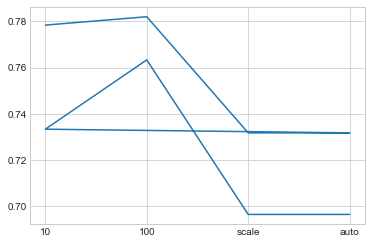

In [25]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','gamma','gammaStr','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for gamma_param in gamma_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                gamma_parameter=gamma_param)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),gamma_parameter=gamma_param)
        result.append(gamma_param)
        result.append(str(gamma_param))
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['gammaStr'],statistics['mae'])
selected_gamma = statistics.sort_values(by=['mae'])['gamma'].head(1).values[0]
print("Selected Gamma Parameter: ",selected_gamma)

#### 14th Experiment - Running the SVR function with the different epsilon parameters

mae       mse      rmse       std       .25       0.5      0.75  \
3  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
4  0.714622  0.849576  0.921724  0.919081 -0.722314  0.080249  0.322432   
5  0.723364  0.846115  0.919845  0.917330 -0.699701  0.066855  0.309159   
0  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   
1  0.749278  0.931008  0.964887  0.966211 -0.700142  0.075387  0.468602   
2  0.753619  0.925805  0.962188  0.963436 -0.641837  0.130270  0.509308   

       0.95       min       max  r-squared  epsilon               type  
3  1.426808 -2.671598  2.033045   0.302213      0.1  Rolling Mean RSSI  
4  1.411514 -2.661874  2.136883   0.288229      0.2  Rolling Mean RSSI  
5  1.329096 -2.609492  1.936765   0.291128      0.3  Rolling Mean RSSI  
0  1.513532 -3.026756  2.153066   0.238449      0.1          RSSI Only  
1  1.556635 -2.880083  2.300321   0.220006      0.2          RSSI Only  
2  1.558790 -2.735307  2.230159   0.224365      0.3          RSSI Only

Selected Epsilon:  0.1


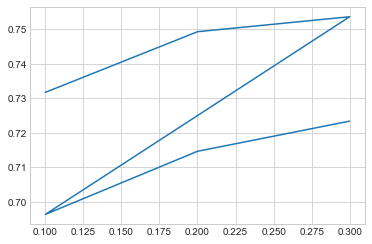

In [26]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','epsilon','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    for epsilon in epsilon_list:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                epsilon_value=epsilon)  
        elif selected_method =='Stratified K-Fold':
            skf = StratifiedKFold(n_splits=selected_fold)
            splited = skf.split(trainX_data,default_groups,groups=default_groups)
            result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                epsilon_value=epsilon)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
            result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(),epsilon_value=epsilon)
        result.append(epsilon)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['epsilon'],statistics['mae'])
selected_epsilon = statistics.sort_values(by=['mae'])['epsilon'].head(1).values[0]
print("Selected Epsilon: ",selected_epsilon)

### Run GridSearch for parameter tunning

In [27]:
results = []
tuned_parameters = {
    'svr__kernel':['rbf'],
    'svr__C':C_parameter_list,
    'svr__gamma':gamma_list,
    'svr__epsilon':epsilon_list
}
scores = ['r2']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    pipe = Pipeline([('standardizer', StandardScaler()), ('svr', SVR())])
    clf = GridSearchCV(
       pipe, tuned_parameters, cv=StratifiedKFold(n_splits=selected_fold, shuffle=True, random_state=6).split(train_X_rolling_mean, default_groups),scoring=score,n_jobs=-1,verbose=1
    )
    clf.fit(train_X_rolling_mean,train_Y.ravel())
    clf.best_params_['score'] = score
    results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results)
display(gridcv_results)

# Tuning hyper-parameters for r2

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    3.2s finished


svr__C  svr__epsilon svr__gamma svr__kernel score
0     1.0           0.3      scale         rbf    r2

### Best Parameters
Display the best parameters tunned throughout the experiments

In [28]:
conclusion_cols=['C Parameter','Cross Validation','Kernel','Preprocessing','Gamma','Epsilon']
conclusion_list = [selected_c_parameter,selected_method,selected_kernel,selected_preprocessing,selected_gamma,selected_epsilon]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

C Parameter   Cross Validation Kernel Preprocessing  Gamma  Epsilon
0          1.0  Stratified K-Fold    rbf          None  scale      0.1

### Best Results
Compute SVR with the best parameters in both RSSI and Rolling Mean

In [32]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','type']
types = ['RSSI Only','Rolling Mean RSSI']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    else:
        trainX_data = train_X_rolling_mean
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=default_groups)
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(trainX_data,default_groups,groups=default_groups)
        result = compute_SVR(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 6,stratify=default_groups)
        result = compute_SVR(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),kernel_parameter=selected_kernel,C_parameter=selected_c_parameter,
                             epsilon_value=selected_epsilon,gamma_parameter=selected_gamma)
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('SVM Regressor')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../proximity_results.csv',mode='a',index=False,header=False)

mae       mse      rmse       std       .25       0.5      0.75  \
1  0.696325  0.832885  0.912625  0.908564 -0.677435  0.029666  0.359841   
0  0.731694  0.908993  0.953411  0.953221 -0.600249 -0.026756  0.400202   

       0.95       min       max  r-squared               type  
1  1.426808 -2.671598  2.033045   0.302213  Rolling Mean RSSI  
0  1.513532 -3.026756  2.153066   0.238449          RSSI Only

### Best Results - Testing data being 1000 plot points
Experiment with testing data of 1000 plot points

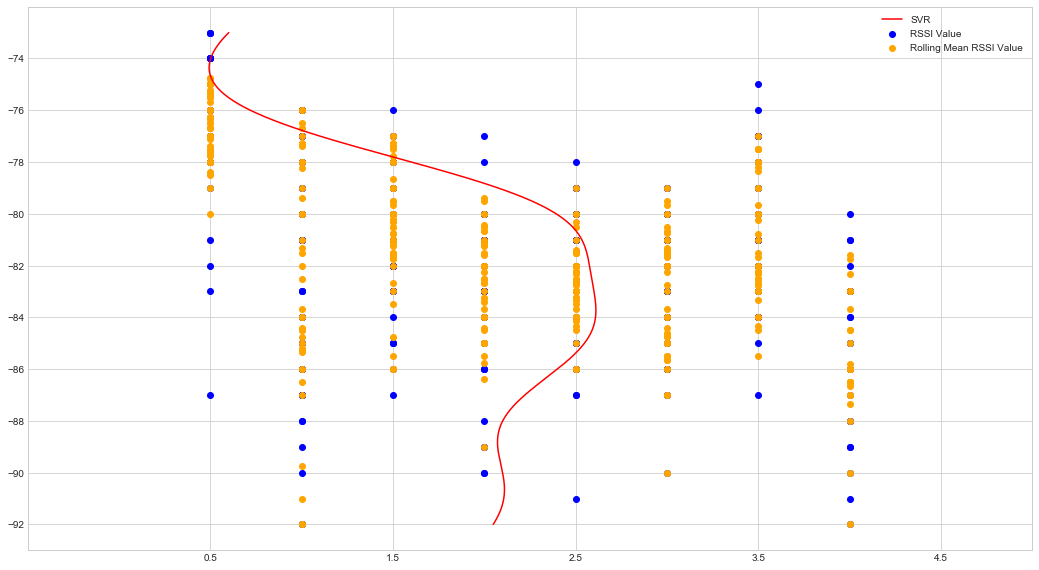

In [31]:
testX_data = np.linspace(dataset['rssi_Value'].min(), dataset['rssi_Value'].max(), 1000).reshape(-1,1)
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
svr_estimator = SVR()
main_estimator = make_pipeline(StandardScaler(),svr_estimator)
main_estimator.fit(train_X_rssi,train_Y.ravel())
predict_test = main_estimator.predict(testX_data)
plt.show()
plt.figure(figsize=(18,10))
plt.scatter(dataset['distance'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['distance'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.xlim(train_Y.min()-1, train_Y.max()+1)
plt.ylim(train_X_rssi.min()-1, train_X_rssi.max()+1)
plt.xticks(np.arange(train_Y.min(), train_Y.max()+1, 1.0))
plt.yticks(np.arange(train_X_rssi.min(), train_X_rssi.max()+1, 2.0))
plt.plot(predict_test, testX_data, color='red', label='SVR')
# Show and place the legent
plt.legend(loc='upper right')
plt.show()